In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import time
from evaluation_metrics import *
from compute_harmony import *

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(20, 10), facecolor='white')

-----
anndata     0.11.3
scanpy      1.10.4
-----
PIL                         11.1.0
anyio                       NA
appnope                     0.1.2
asttokens                   NA
attr                        24.3.0
attrs                       24.3.0
babel                       2.16.0
backports                   NA
brotli                      1.0.9
certifi                     2025.01.31
charset_normalizer          3.3.2
comm                        0.2.1
compute_harmony             NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.11
decorator                   5.1.1
defusedxml                  0.7.1
evaluation_metrics          NA
exceptiongroup              1.2.0
executing                   0.8.3
fastjsonschema              NA
h5py                        3.12.1
idna                        3.7
ipykernel                   6.29.5
ipywidgets                  8.1.5
jaraco                      NA
jedi 

In [3]:
df_fov = pd.read_pickle('mk_bc_fov.pkl')
df_fov = df_fov[df_fov.index != 'OFFx']
df_fov

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
DB3b,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMB,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB5*,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB5*,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Generate unique mapping for index values
unique_index_values = df_fov.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_fov.index = df_fov.index.map(index_mapping)
df_fov

Mapping of annotated values to numbers:
{'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'DB3a': 10}


GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# fov_index_mapping = {'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'OFFx': 10, 'DB3a': 11}
fov_index_mapping = {'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'DB3a': 10}
fov_bc_mapping = {value: key for key, value in fov_index_mapping.items()}
fov_bc_mapping

{0: 'DB3b',
 1: 'FMB',
 2: 'IMB',
 3: 'DB5*',
 4: 'DB4',
 5: 'DB2',
 6: 'DB1',
 7: 'BB/GB*',
 8: 'RB',
 9: 'DB6',
 10: 'DB3a'}

In [6]:
# transform cell type index into a number between 100 and 200
df_fov.index = df_fov.index+101
df_fov

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
101,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_per = pd.read_pickle('mk_bc_per.pkl')
df_per

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
FMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
FMB,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
DB2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
IMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [8]:
# Generate unique mapping for index values
unique_index_values = df_per.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_per.index = df_per.index.map(index_mapping)
df_per

Mapping of annotated values to numbers:
{'RB': 0, 'FMB': 1, 'DB2': 2, 'IMB': 3, 'DB5*': 4, 'DB3b': 5, 'DB3a': 6, 'BB/GB*': 7, 'DB1': 8, 'DB4': 9, 'DB6': 10}


GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
1,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [9]:
per_index_mapping = {'RB': 0, 'FMB': 1, 'DB2': 2, 'IMB': 3, 'DB5*': 4, 'DB3b': 5, 'DB3a': 6, 'BB/GB*': 7, 'DB1': 8, 'DB4': 9, 'DB6': 10}
per_bc_mapping = {value: key for key, value in per_index_mapping.items()}
per_bc_mapping

{0: 'RB',
 1: 'FMB',
 2: 'DB2',
 3: 'IMB',
 4: 'DB5*',
 5: 'DB3b',
 6: 'DB3a',
 7: 'BB/GB*',
 8: 'DB1',
 9: 'DB4',
 10: 'DB6'}

In [10]:
# transform cell type index into a number above 200
df_per.index = df_per.index+201
df_per

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
202,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
202,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
203,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
204,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [11]:
df = pd.concat([df_fov, df_per], axis=0)
df

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
101,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
103,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [12]:
# Calculate counts, means, and variances per cell type
type_counts = df.groupby(df.index).count()  # Count of cells per type
type_means = df.groupby(df.index).mean()    # Mean expression per type
type_vars = df.groupby(df.index).var()      # Variance per type

# Calculate SEM for each type
type_sems = type_vars.div(type_counts - 1).pow(0.5)  # SEM = sqrt(var/(n-1))

# Calculate overall mean expression for each gene
overall_means = df.mean()

# Calculate signal
signal = ((type_means - overall_means)**2).sum()

# Calculate noise
noise = (type_sems**2).sum()

# Calculate SNR, avoiding division by zero
snr = signal / np.maximum(noise, 1e-20)

# Sort genes by SNR in descending order
sorted_genes = snr.sort_values(ascending=False)

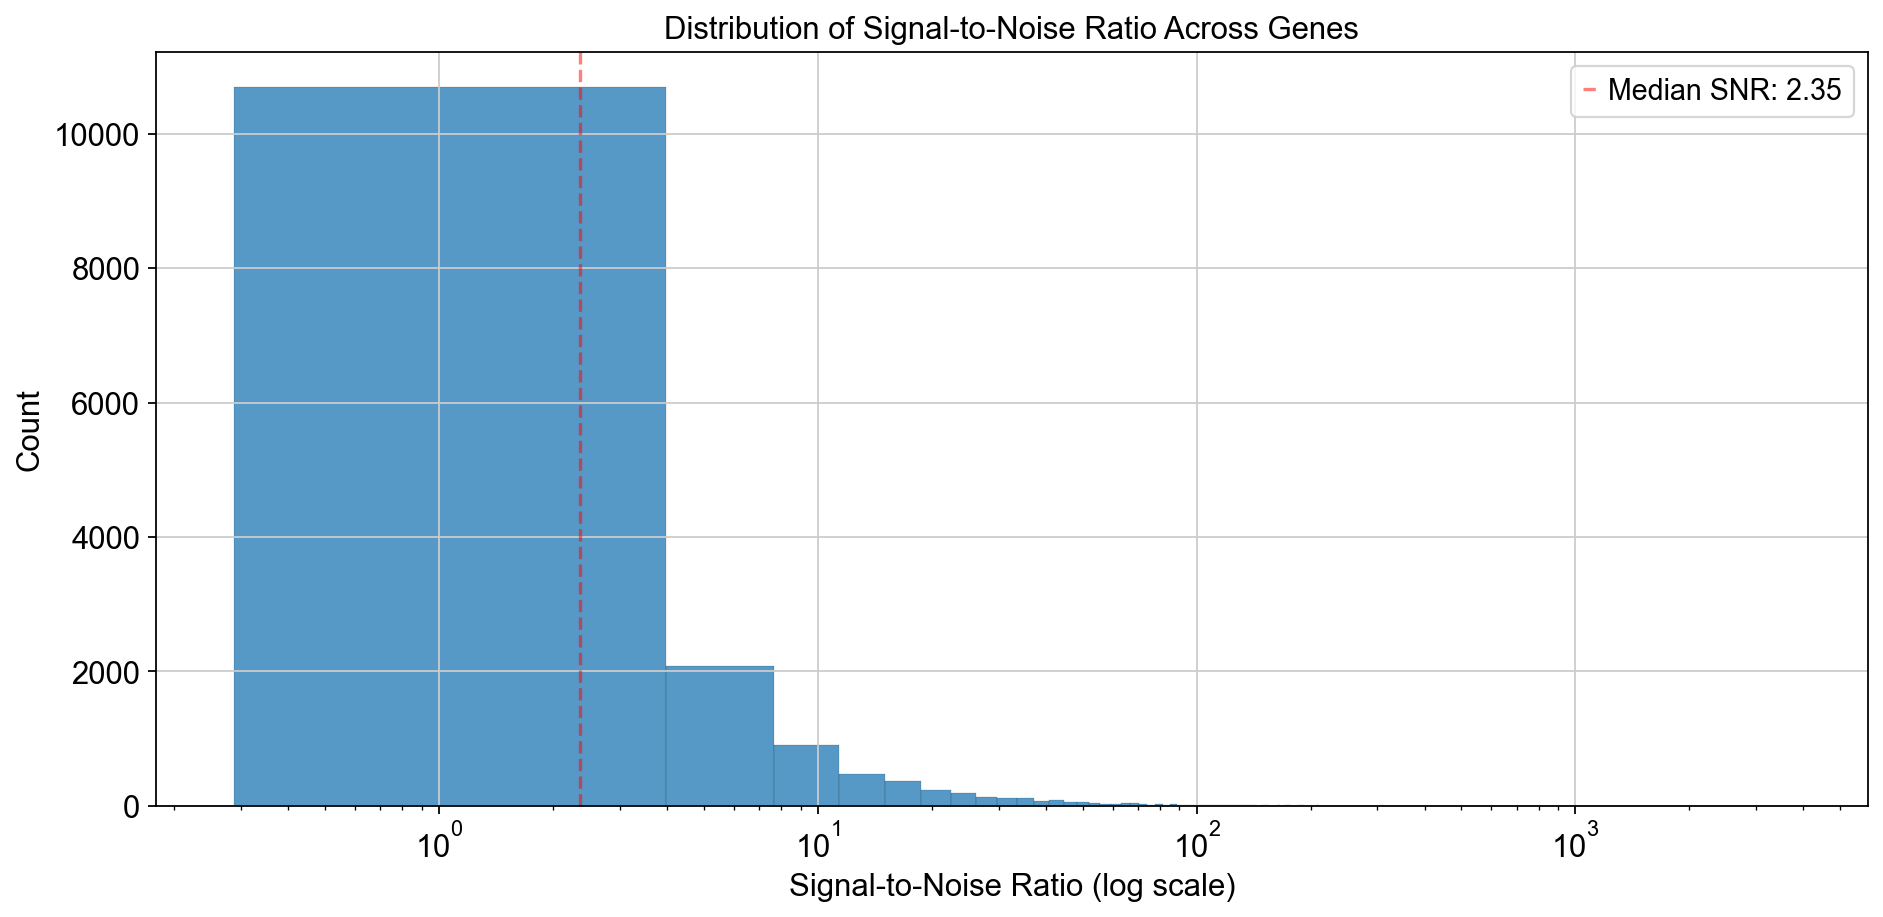


SNR Summary Statistics:
count    16161.000000
mean        10.884119
std         52.221137
min          0.286768
25%          1.365612
50%          2.353347
75%          6.032673
max       3688.980919
dtype: float64


In [13]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
sns.histplot(data=snr, bins=1000)

# Add log scale for x-axis since SNR values often span several orders of magnitude
plt.xscale('log')

# Customize the plot
plt.title('Distribution of Signal-to-Noise Ratio Across Genes')
plt.xlabel('Signal-to-Noise Ratio (log scale)')
plt.ylabel('Count')

# Add grid for better readability
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Optional: Add vertical line at median
plt.axvline(snr.median(), color='r', linestyle='--', alpha=0.5, label=f'Median SNR: {snr.median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSNR Summary Statistics:")
print(snr.describe())

In [14]:
# Select genes with high SNR
high_snr_genes = snr[snr > 100]

# Print number of selected genes
print(f"Number of genes with great SNR: {len(high_snr_genes)}")

# Create filtered dataframe with only high SNR genes
df_filtered = df[high_snr_genes.index]

# Optional: Display first few rows and shape of filtered dataframe
print(f"\nShape of filtered dataframe: {df_filtered.shape}")
print("\nFirst few rows of filtered dataframe:")
print(df_filtered.head())

Number of genes with great SNR: 271

Shape of filtered dataframe: (30155, 271)

First few rows of filtered dataframe:
GENE   PROX1_p     TGFB2  KCNA3  MSTRG.1569     STMN1  RAP1GAP     RGS16  \
101   0.000000  0.000000    0.0    0.641217  0.000000      0.0  0.000000   
102   0.000000  0.000000    0.0    0.000000  0.000000      0.0  0.000000   
103   0.000000  0.000000    0.0    0.782327  1.517249      0.0  0.782327   
104   1.036175  0.000000    0.0    0.000000  1.036175      0.0  0.000000   
105   0.980239  0.605707    0.0    0.000000  0.605707      0.0  0.000000   

GENE  LOC102135846      NEK2    LPGAT1  ...  MSTRG.22359  MSTRG.22360  \
101            0.0  0.000000  0.000000  ...     0.641217     3.033673   
102            0.0  1.392702  0.000000  ...     0.697424     1.392702   
103            0.0  0.000000  0.000000  ...     0.782327     2.457792   
104            0.0  0.000000  0.646688  ...     0.000000     2.954085   
105            0.0  0.000000  0.000000  ...     0.980239    

In [15]:
fov_sub_df = df_filtered[df_filtered.index < 200]
per_sub_df = df_filtered[df_filtered.index >= 200]

# Print information about the split
print(f"Fovea dataframe shape: {fov_sub_df.shape}")
print(f"Peripheral dataframe shape: {per_sub_df.shape}")

# Optional: Display first few rows of each
print("\nFirst few rows of fovea dataframe:")
print(fov_sub_df.head())
print("\nFirst few rows of peripheral dataframe:")
print(per_sub_df.head())

Fovea dataframe shape: (20870, 271)
Peripheral dataframe shape: (9285, 271)

First few rows of fovea dataframe:
GENE   PROX1_p     TGFB2  KCNA3  MSTRG.1569     STMN1  RAP1GAP     RGS16  \
101   0.000000  0.000000    0.0    0.641217  0.000000      0.0  0.000000   
102   0.000000  0.000000    0.0    0.000000  0.000000      0.0  0.000000   
103   0.000000  0.000000    0.0    0.782327  1.517249      0.0  0.782327   
104   1.036175  0.000000    0.0    0.000000  1.036175      0.0  0.000000   
105   0.980239  0.605707    0.0    0.000000  0.605707      0.0  0.000000   

GENE  LOC102135846      NEK2    LPGAT1  ...  MSTRG.22359  MSTRG.22360  \
101            0.0  0.000000  0.000000  ...     0.641217     3.033673   
102            0.0  1.392702  0.000000  ...     0.697424     1.392702   
103            0.0  0.000000  0.000000  ...     0.782327     2.457792   
104            0.0  0.000000  0.646688  ...     0.000000     2.954085   
105            0.0  0.000000  0.000000  ...     0.980239     3.043

In [16]:
# transform the index back to cell type names
per_sub_df.index = per_sub_df.index - 201
# per_sub_df.index = per_sub_df.index.map(per_bc_mapping)
# per_sub_df

In [17]:
# transform the index back to cell type names
fov_sub_df.index = fov_sub_df.index - 101
# fov_sub_df.index = fov_sub_df.index.map(fov_bc_mapping)
# fov_sub_df

In [18]:
# Run Harmony with 1NN
labels_per = per_sub_df.index
labels_fov = fov_sub_df.index

cm_harmony = harmony_1nn_mapping(
    per_sub_df, fov_sub_df, labels_per, labels_fov,
    source_name="Peripheral", target_name="Fovea"
)

# Map indices back to cell type names
cm_harmony.index = cm_harmony.index.map(fov_bc_mapping)
cm_harmony.columns = cm_harmony.columns.map(per_bc_mapping)

Running Harmony integration...
computing PCA
    with n_comps=50


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:01)


2025-05-24 23:48:31,028 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-24 23:48:33,210 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-24 23:48:33,275 - harmonypy - INFO - Iteration 1 of 10
2025-05-24 23:48:36,666 - harmonypy - INFO - Iteration 2 of 10
2025-05-24 23:48:39,991 - harmonypy - INFO - Iteration 3 of 10
2025-05-24 23:48:43,352 - harmonypy - INFO - Converged after 3 iterations


Performing 1NN assignment...
Running Time: 14.530559 seconds


In [19]:
# for plotting in the same order as that in Peng, et al. (2019)
desired_order1 = [
    "FMB",    # FMB (top)
    "DB1",    # DB1
    # "OFFx",   # OFFx
    "DB2",    # DB2
    "DB3a",   # DB3a
    "DB3b",   # DB3b
    "IMB",    # IMB
    "DB4",    # DB4
    "BB/GB*", # BB/GB*
    "DB6",    # DB6
    "DB5*",   # DB5*
    "RB"      # RB (bottom)
]

desired_order2 = [
    "FMB",    # FMB (top)
    "DB1",    # DB1
    "DB2",    # DB2
    "DB3a",   # DB3a
    "DB3b",   # DB3b
    "IMB",    # IMB
    "DB4",    # DB4
    "BB/GB*", # BB/GB*
    "DB6",    # DB6
    "DB5*",   # DB5*
    "RB"      # RB (bottom)
]

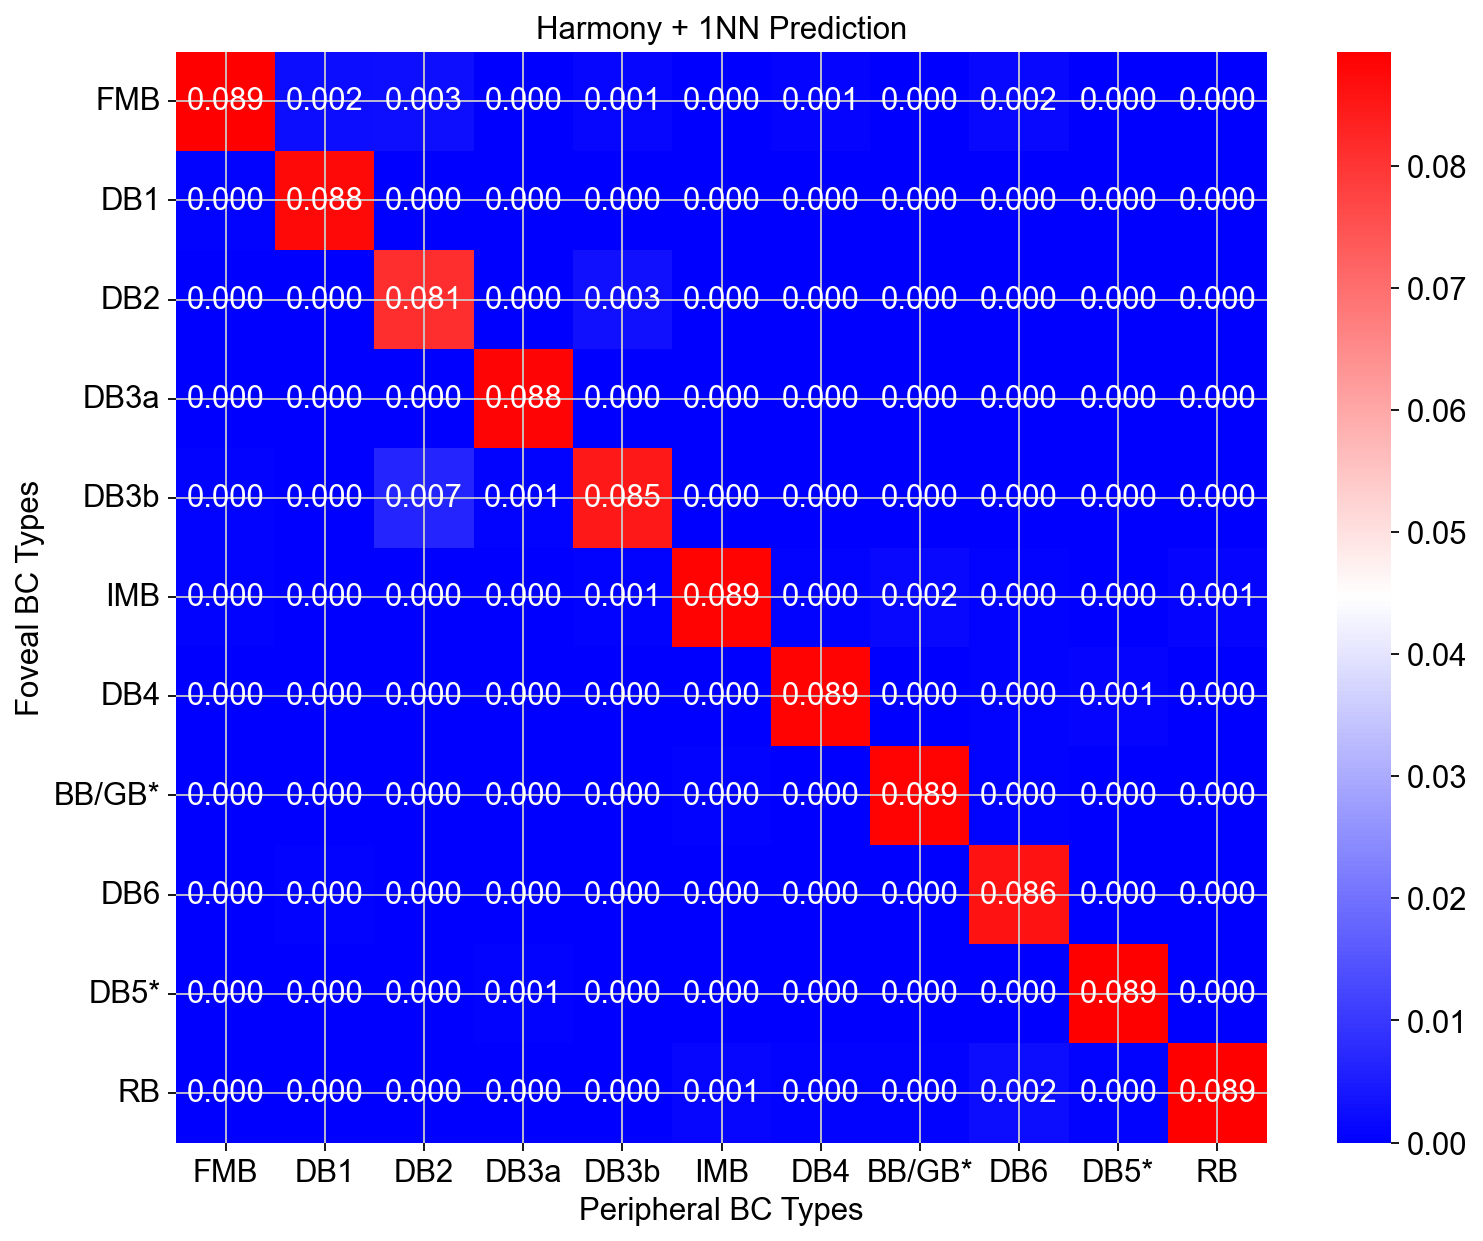

In [20]:
existing_columns = [col for col in desired_order2 if col in cm_harmony.columns]
existing_rows = [row for row in desired_order1 if row in cm_harmony.index]

# Reindex both dimensions
cm_harmony_ordered = cm_harmony.reindex(index=existing_rows, columns=existing_columns)

# Normalize the matrix
cm_harmony_ordered = cm_harmony_ordered / cm_harmony_ordered.values.sum()

# %%
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_harmony_ordered, cmap='bwr', square=True,
            annot=True, fmt='.3f')
plt.title("Harmony + 1NN Prediction")
plt.xlabel("Peripheral BC Types")
plt.ylabel("Foveal BC Types")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./Plots/harmony_1nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Calculate evaluation metrics
matrix = cm_harmony_ordered

# Ensure the matrix is normalized
if not np.isclose(matrix.values.sum(), 1.0):
    matrix = matrix / matrix.values.sum()

# Calculate metrics
sparseness = sparseness_score(matrix.values)
entropy_value = entropy(matrix.values)
adi = adjusted_rand_index_from_confusion_matrix(matrix.values)

# Print results
print("\nHarmony + 1NN Correspondence Matrix Evaluation Results:")
print("-----------------------------------------------------")
print(f"Sparseness Score: {sparseness:.4f}")
print(f"Entropy: {entropy_value:.4f}")
print(f"ADI: {adi:.4f}")

# Additional information about the matrix
print("\nMatrix Information:")
print(f"Shape: {matrix.shape}")
print(f"Number of cells: {matrix.size}")
print(f"Number of cells with value > 0.001: {np.sum(matrix.values > 0.001)}")
print(f"Maximum value: {matrix.values.max():.4f}")

# Calculate density (opposite of sparseness)
density = 1 - sparseness
print(f"Density (1-sparseness): {density:.4f}")

# Calculate concentration metrics
diag_sum = np.sum(np.diag(matrix.values)) if matrix.shape[0] == matrix.shape[1] else 0
print(f"Sum of diagonal elements: {diag_sum:.4f}")


Harmony + 1NN Correspondence Matrix Evaluation Results:
-----------------------------------------------------
Sparseness Score: 0.8347
Entropy: 2.5949
ADI: 0.9258

Matrix Information:
Shape: (11, 11)
Number of cells: 121
Number of cells with value > 0.001: 20
Maximum value: 0.0893
Density (1-sparseness): 0.1653
Sum of diagonal elements: 0.9625
